In [74]:
import numpy as np 
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd

In [30]:
# Load data
train = np.load('master_data/train.npy')
test = np.load('master_data/test.npy')
print(train.shape, test.shape)

(151, 250, 363) (38, 250, 363)


In [31]:
train_batches = train.shape[0] # N hereafter. Number of training images in database.
length = train.shape[1] 
stocks = train.shape[2]

## VAE

In [109]:
# -*- coding: utf-8 -*-
import torch
import torch.optim as optim
import torch.nn as nn

lrelu = nn.LeakyReLU(0.2)

class Network():
    
    def backward_pass(self, loss):
        # Performs back propagation and computes gradients
        # With PyTorch, we do not need to compute gradients analytically for parameters were requires_grads=True, 
        # Calling loss.backward(), torch's Autograd automatically computes grads of loss wrt each parameter p,...
        # ... and **puts them in p.grad**. Return them in a list.
        loss.backward()
        grads = [param.grad for param in self.params]
        return grads
    
    
class VAE_2(Network):
    def __init__(self, rng, D_in):
        # Construct and initialize network parameters
        D_in = D_in # Dimension of input feature-vectors. Length of a vectorised image.
        D_enc_1 = 80 # Dimension of Encoder's hidden layer
        D_enc_2 = 40
        D_enc_3 = 20
        D_enc_4 = 10
        D_bottleneck = 2
        D_dec_1 = 10
        D_dec_2 = 20
        D_dec_3 = 40
        D_dec_4 = 80
        D_dec_5 = 160
        D_out = D_in # Dimension of Output layer.
        
        self.D_bottleneck = D_bottleneck  # Keep track of it, we will need it.
        
        ##### TODO: Initialize the VAE's parameters. Also see forward_pass(...)) ########
        # Dimensions of parameter tensors are (number of neurons + 1) per layer, to account for +1 bias.
        # -- (Encoder) 
        w_enc_1_int = rng.normal(loc=0.0, scale=0.01, size=(D_in+1, D_enc_1))
        w_enc_2_int = rng.normal(loc=0.0, scale=0.01, size=(D_enc_1+1, D_enc_2))
        w_enc_3_int = rng.normal(loc=0.0, scale=0.01, size=(D_enc_2+1, D_enc_3))
        w_enc_4_int = rng.normal(loc=0.0, scale=0.01, size=(D_enc_3+1, D_enc_4))
        # -- (Encoder)  predicting p(z|x)
        w_mu_init = rng.normal(loc=0.0, scale=0.01, size=(D_enc_4+1, D_bottleneck))
        w_std_init = rng.normal(loc=0.0, scale=0.01, size=(D_enc_4+1, D_bottleneck))
        # -- (Decoder) layer 3
        w_dec_1_init = rng.normal(loc=0.0, scale=0.01, size=(D_bottleneck+1, D_dec_1))
        w_dec_2_init = rng.normal(loc=0.0, scale=0.01, size=(D_dec_1+1, D_dec_2))
        w_dec_3_init = rng.normal(loc=0.0, scale=0.01, size=(D_dec_2+1, D_dec_3))
        w_dec_4_init = rng.normal(loc=0.0, scale=0.01, size=(D_dec_3+1, D_dec_4))
        w_dec_5_init = rng.normal(loc=0.0, scale=0.01, size=(D_dec_4+1, D_dec_5))
        # -- (Decoder) layer 4, the output layer
        w_out_init = rng.normal(loc=0.0, scale=0.01, size=(D_dec_5+1, D_out))
        
        # Pytorch tensors, parameters of the model
        # Use the above numpy arrays as of random floats as initialization for the Pytorch weights.
        # (Encoder)
        w_enc_1 = torch.tensor(w_enc_1_int, dtype=torch.float, requires_grad=True)
        w_enc_2 = torch.tensor(w_enc_2_int, dtype=torch.float, requires_grad=True)
        w_enc_3 = torch.tensor(w_enc_3_int, dtype=torch.float, requires_grad=True)
        w_enc_4 = torch.tensor(w_enc_4_int, dtype=torch.float, requires_grad=True)
        # (Encoder) predicting p(z|x)
        w_mu = torch.tensor(w_mu_init, dtype=torch.float, requires_grad=True)
        w_std = torch.tensor(w_std_init, dtype=torch.float, requires_grad=True)
        # (Decoder)
        w_dec_1 = torch.tensor(w_dec_1_init, dtype=torch.float, requires_grad=True)
        w_dec_2 = torch.tensor(w_dec_2_init, dtype=torch.float, requires_grad=True)
        w_dec_3 = torch.tensor(w_dec_3_init, dtype=torch.float, requires_grad=True)
        w_dec_4 = torch.tensor(w_dec_4_init, dtype=torch.float, requires_grad=True)
        w_dec_5 = torch.tensor(w_dec_5_init, dtype=torch.float, requires_grad=True)
        # (Decoder) output layer
        w_out = torch.tensor(w_out_init, dtype=torch.float, requires_grad=True)
        # Keep track of all trainable parameters:
        self.params = [w_enc_1, w_enc_2, w_enc_3, w_enc_4, w_mu, w_std, w_dec_1, w_dec_2, w_dec_3, w_dec_4, w_dec_5, w_out]
        ###########################################################################
        
    
    def encode(self, batch):
        # batch_imgs: Numpy array or Pytorch tensor of shape: [number of inputs, dimensionality of x]
        [w_enc_1, w_enc_2, w_enc_3, w_enc_4, w_mu, w_std, w_dec_1, w_dec_2, w_dec_3, w_dec_4, w_dec_5, w_out] = self.params
        
        batch_t = torch.tensor(batch, dtype=torch.float) if type(batch) is np.ndarray else batch
        
        unary_feature_for_bias = torch.ones(size=(batch_t.shape[0], 1)) # [N, 1] column vector.
        x = torch.cat((batch_t, unary_feature_for_bias), dim=1) # Extra feature=1 for bias.
        
        # ========== TODO: Fill in the gaps with the correct parameters of the VAE ========
        # Encoder's Layer 1
        h1_preact = x.mm(w_enc_1)
        h1_act = h1_preact.clamp(min=0)
        h1_ext = torch.cat((h1_act, unary_feature_for_bias), dim=1)
        # Encoder's Layer 2
        h2_preact = h1_ext.mm(w_enc_2)
        h2_act = h2_preact.clamp(min=0)
        h2_ext = torch.cat((h2_act, unary_feature_for_bias), dim=1)
        # Encoder's Layer 3
        h3_preact = h2_ext.mm(w_enc_3)
        h3_act = h3_preact.clamp(min=0)
        h3_ext = torch.cat((h3_act, unary_feature_for_bias), dim=1)
        # Encoder's Layer 4
        h4_preact = h3_ext.mm(w_enc_4)
        h4_act = h4_preact.clamp(min=0)
        h4_ext = torch.cat((h4_act, unary_feature_for_bias), dim=1)
        # Encoder's Layer 5 (predicting p(z|x) of Z coding):
        # ... mu
        h5_mu_preact = h4_ext.mm(w_mu)
        h5_mu_act = h5_mu_preact
        # ... log(std). Ask yourselves: Why do we do this, instead of directly predicting std deviation?
        h5_logstd_preact = h4_ext.mm(w_std)
        h5_logstd_act = h5_logstd_preact  # No (linear) activation function in this tutorial, but can use any.
        # ==============================================================================
        z_coding = (h5_mu_act, h5_logstd_act)
        
        return z_coding
        
        
    def decode(self, z_codes):
        # z_codes: numpy array or pytorch tensor, shape [N, dimensionality of Z]
        [w_enc_1, w_enc_2, w_enc_3, w_enc_4, w_mu, w_std, w_dec_1, w_dec_2, w_dec_3, w_dec_4, w_dec_5, w_out] = self.params
        
        z_codes_t = torch.tensor(z_codes, dtype=torch.float) if type(z_codes) is np.ndarray else z_codes
        
        unary_feature_for_bias = torch.ones(size=(z_codes_t.shape[0], 1)) # [N, 1] column vector.
        
        # ========== TODO: Fill in the gaps with the correct parameters of the VAE ========
        # Decoder's 1st layer (Layer 6 of whole VAE):
        h1_ext = torch.cat((z_codes_t, unary_feature_for_bias), dim=1)
        h1_preact = h1_ext.mm(w_dec_1)
        h1_act = h1_preact.clamp(min=0)
        # Decoder's 2nd layer (Layer 7 of whole VAE):
        h2_ext = torch.cat((h1_act, unary_feature_for_bias), dim=1)
        h2_preact = h2_ext.mm(w_dec_2)
        h2_act = h2_preact.clamp(min=0)
        # Decoder's 3rd layer (Layer 8 of whole VAE):
        h3_ext = torch.cat((h2_act, unary_feature_for_bias), dim=1)
        h3_preact = h3_ext.mm(w_dec_3)
        h3_act = h3_preact.clamp(min=0)
        # Decoder's 4th layer (Layer 9 of whole VAE):
        h4_ext = torch.cat((h3_act, unary_feature_for_bias), dim=1)
        h4_preact = h4_ext.mm(w_dec_4)
        h4_act = h4_preact.clamp(min=0)
        # Decoder's 5th layer (Layer 10 of whole VAE):
        h5_ext = torch.cat((h4_act, unary_feature_for_bias), dim=1)
        h5_preact = h5_ext.mm(w_dec_5)
        h5_act = h5_preact.clamp(min=0)
        # Decoder's 6th layer (Layer 11 of whole VAE):
        h6_ext = torch.cat((h5_act, unary_feature_for_bias), dim=1)
        h6_preact = h6_ext.mm(w_out)
        h6_act = torch.tanh(h6_preact)
        # ==============================================================================
        # Output
        x_pred = h6_act
        
        return x_pred
        
        
    def sample_with_reparameterization(self, z_mu, z_logstd):
        # Reparameterization trick to sample from N(mu, var) using N(0,1) as intermediate step.
        # param z_mu: Tensor. Mean of the predicted Gaussian p(z|x). Shape: [Num samples, Dimensionality of Z]
        # param z_logstd: Tensor. Log of standard deviation of predicted Gaussian p(z|x). [Num samples, Dim of Z]
        # return: Tensor. [Num samples, Dim of Z]
        
        N_samples = z_mu.shape[0]
        Z_dims = z_mu.shape[1]

        # ========== TODO: Fill in the gaps to complete the reparameterization trick ========
        z_std = torch.exp(z_logstd)       #   <--------------- ?????????
        eps = torch.randn(size=[N_samples, Z_dims])  # Samples from N(0,I)
        z_samples = z_mu + z_std * eps    #           <--------------- ?????????
        # ==============================================================================
        
        return z_samples
        
        
    def forward_pass(self, batch_imgs):
        batch_imgs_t = torch.tensor(batch_imgs, dtype=torch.float)  # Makes numpy array to pytorch tensor.
        
        # ========== TODO: Call the appropriate functions, as you defined them above ========
        # Encoder
        z_mu, z_logstd = self.encode(batch_imgs_t)  # <------------- ????????????
        z_samples = self.sample_with_reparameterization(z_mu, z_logstd)  # <------------- ????????????
        # Decoder
        x_pred = self.decode(z_samples)  # <------------- ????????????
        # ===================================================================================
        
        return (x_pred, z_mu, z_logstd, z_samples)

   
class VAE(Network):
    def __init__(self, rng, D_in, D_hid_enc, D_bottleneck, D_hid_dec):
        # Construct and initialize network parameters
        D_in = D_in # Dimension of input feature-vectors. Length of a vectorised image.
        D_hid_1 = D_hid_enc # Dimension of Encoder's hidden layer
        D_hid_2 = D_bottleneck
        D_hid_3 = D_hid_dec  # Dimension of Decoder's hidden layer
        D_out = D_in # Dimension of Output layer.
        
        self.D_bottleneck = D_bottleneck  # Keep track of it, we will need it.
        
        ##### TODO: Initialize the VAE's parameters. Also see forward_pass(...)) ########
        # Dimensions of parameter tensors are (number of neurons + 1) per layer, to account for +1 bias.
        # -- (Encoder) layer 1
        w1_init = rng.normal(loc=0.0, scale=0.01, size=(D_in+1, D_hid_1))
        # -- (Encoder) layer 2, predicting p(z|x)
        w2_mu_init = rng.normal(loc=0.0, scale=0.01, size=(D_hid_1+1, D_hid_2))
        w2_std_init = rng.normal(loc=0.0, scale=0.01, size=(D_hid_1+1, D_hid_2))
        # -- (Decoder) layer 3
        w3_init = rng.normal(loc=0.0, scale=0.01, size=(D_hid_2+1, D_hid_3))
        # -- (Decoder) layer 4, the output layer
        w4_init = rng.normal(loc=0.0, scale=0.01, size=(D_hid_3+1, D_out))
        
        # Pytorch tensors, parameters of the model
        # Use the above numpy arrays as of random floats as initialization for the Pytorch weights.
        # (Encoder)
        w1 = torch.tensor(w1_init, dtype=torch.float, requires_grad=True)
        # (Encoder) Layer 2, predicting p(z|x)
        w2_mu = torch.tensor(w2_mu_init, dtype=torch.float, requires_grad=True)
        w2_std = torch.tensor(w2_std_init, dtype=torch.float, requires_grad=True)
        # (Decoder)
        w3 = torch.tensor(w3_init, dtype=torch.float, requires_grad=True)
        w4 = torch.tensor(w4_init, dtype=torch.float, requires_grad=True)
        # Keep track of all trainable parameters:
        self.params = [w1, w2_mu, w2_std, w3, w4]
        ###########################################################################
        
    
    def encode(self, batch_imgs):
        # batch_imgs: Numpy array or Pytorch tensor of shape: [number of inputs, dimensionality of x]
        [w1, w2_mu, w2_std, w3, w4] = self.params
        
        batch_imgs_t = torch.tensor(batch_imgs, dtype=torch.float) if type(batch_imgs) is np.ndarray else batch_imgs
        
        unary_feature_for_bias = torch.ones(size=(batch_imgs_t.shape[0], 1)) # [N, 1] column vector.
        x = torch.cat((batch_imgs_t, unary_feature_for_bias), dim=1) # Extra feature=1 for bias.
        
        # ========== TODO: Fill in the gaps with the correct parameters of the VAE ========
        # Encoder's Layer 1
        h1_preact = x.mm(w1)
        h1_act = h1_preact.clamp(min=0)
        # Encoder's Layer 2 (predicting p(z|x) of Z coding):
        h1_ext = torch.cat((h1_act, unary_feature_for_bias), dim=1)
        # ... mu
        h2_mu_preact = h1_ext.mm(w2_mu)   # <------------- ????????
        h2_mu_act = h2_mu_preact
        # ... log(std). Ask yourselves: Why do we do this, instead of directly predicting std deviation?
        h2_logstd_preact = h1_ext.mm(w2_std)  # <-------------- ???????
        h2_logstd_act = h2_logstd_preact  # No (linear) activation function in this tutorial, but can use any.
        # ==============================================================================
        
        z_coding = (h2_mu_act, h2_logstd_act)
        
        return z_coding
        
        
    def decode(self, z_codes):
        # z_codes: numpy array or pytorch tensor, shape [N, dimensionality of Z]
        [w1, w2_mu, w2_std, w3, w4] = self.params
        
        z_codes_t = torch.tensor(z_codes, dtype=torch.float) if type(z_codes) is np.ndarray else z_codes
        
        unary_feature_for_bias = torch.ones(size=(z_codes_t.shape[0], 1)) # [N, 1] column vector.
        
        # ========== TODO: Fill in the gaps with the correct parameters of the VAE ========
        # Decoder's 1st layer (Layer 3 of whole VAE):
        h2_ext = torch.cat((z_codes_t, unary_feature_for_bias), dim=1)
        h3_preact = h2_ext.mm(w3)  # < ----------------------------------
        h3_act = h3_preact.clamp(min=0)
        # Decoder's 2nd layer (Layer 4 of whole VAE): The output layer.
        h3_ext = torch.cat((h3_act, unary_feature_for_bias), dim=1)
        h4_preact = h3_ext.mm(w4)
        h4_act = torch.tanh(h4_preact)
        # ==============================================================================
        
        # Output
        x_pred = h4_act
        
        return x_pred
        
        
    def sample_with_reparameterization(self, z_mu, z_logstd):
        # Reparameterization trick to sample from N(mu, var) using N(0,1) as intermediate step.
        # param z_mu: Tensor. Mean of the predicted Gaussian p(z|x). Shape: [Num samples, Dimensionality of Z]
        # param z_logstd: Tensor. Log of standard deviation of predicted Gaussian p(z|x). [Num samples, Dim of Z]
        # return: Tensor. [Num samples, Dim of Z]
        
        N_samples = z_mu.shape[0]
        Z_dims = z_mu.shape[1]

        # ========== TODO: Fill in the gaps to complete the reparameterization trick ========
        z_std = torch.exp(z_logstd)       #   <--------------- ?????????
        eps = torch.randn(size=[N_samples, Z_dims])  # Samples from N(0,I)
        z_samples = z_mu + z_std * eps    #           <--------------- ?????????
        # ==============================================================================
        
        return z_samples
        
        
    def forward_pass(self, batch_imgs):
        batch_imgs_t = torch.tensor(batch_imgs, dtype=torch.float)  # Makes numpy array to pytorch tensor.
        
        # ========== TODO: Call the appropriate functions, as you defined them above ========
        # Encoder
        z_mu, z_logstd = self.encode(batch_imgs_t)  # <------------- ????????????
        z_samples = self.sample_with_reparameterization(z_mu, z_logstd)  # <------------- ????????????
        # Decoder
        x_pred = self.decode(z_samples)  # <------------- ????????????
        # ===================================================================================
        
        return (x_pred, z_mu, z_logstd, z_samples)

        
def reconstruction_loss(x_pred, x_real, eps=1e-7):
    # x_pred: [N, D_out] Prediction returned by forward_pass. Numpy array of shape [N, D_out]
    # x_real: [N, D_in]
    
    # If number array is given, change it to a Torch tensor.
    x_pred = torch.tensor(x_pred, dtype=torch.float) if type(x_pred) is np.ndarray else x_pred
    x_real = torch.tensor(x_real, dtype=torch.float) if type(x_real) is np.ndarray else x_real
    
    ######## TODO: Complete the calculation of Reconstruction loss for each sample ###########
    loss_recon = torch.mean(torch.square(x_pred - x_real), dim=1)
    ##########################################################################################
    
    cost = torch.mean(loss_recon, dim=0) # Expectation of loss: Mean over samples (axis=0).
    
    return cost


def regularizer_loss(mu, log_std):
    # mu: Tensor, [number of samples, dimensionality of Z]. Predicted means per z dimension
    # log_std: Tensor, [number of samples, dimensionality of Z]. Predicted log(std.dev.) per z dimension.
    
    ######## TODO: Complete the calculation of Reconstruction loss for each sample ###########
    std = torch.exp(log_std)  # Compute std.dev. from log(std.dev.)
    reg_loss_per_sample = 0.5 * torch.sum(mu**2 + std**2 - 2 * log_std - 1, dim = 1)  # <----------
    reg_loss = torch.mean(reg_loss_per_sample, dim = 0)  # Mean over samples.
    ##########################################################################################
    
    return reg_loss


def vae_loss(x_real, x_pred, z_mu, z_logstd, lambda_rec=1., lambda_reg=0.005, eps=1e-7):
    
    rec_loss = reconstruction_loss(x_pred, x_real, eps=1e-7)
    reg_loss = regularizer_loss(z_mu, z_logstd)
    
    ################### TODO: compute the total loss: #####################################
    # ...by weighting the reconstruction loss by lambda_rec, and the Regularizer by lambda_reg
    weighted_rec_loss = lambda_rec * rec_loss
    weighted_reg_loss = lambda_reg * reg_loss
    total_loss = weighted_rec_loss + weighted_reg_loss
    #######################################################################################
    
    return total_loss, weighted_rec_loss, weighted_reg_loss
    
    

In [110]:
from plotting import plot_train_progress_VAE, plot_grids_of_images  # Use out of the box


def get_random_batch(train, rng, train_batches, length, stocks):
    batch = rng.randint(low=0, high=train_batches, size=1, dtype='int32')
    # print('Using batch:', batch, 'of', train.shape[0])
    train_batch= train[batch]
    train_batch= train_batch.reshape(length, stocks)
    # train_batch = train_batch[:, np.random.permutation(train_batch.shape[1])]
    return np.transpose(train_batch)


def unsupervised_training_VAE(net,
                             loss_func,
                             lambda_rec,
                             lambda_reg,
                             rng,
                             train,
                             learning_rate,
                             total_iters,
                             iters_per_recon_plot=-1):
    # net: Instance of a model. See classes: Autoencoder, MLPClassifier, etc further below
    # loss_func: Function that computes the loss. See functions: reconstruction_loss or cross_entropy.
    # lambda_rec: weighing of reconstruction loss in total loss. Total = lambda_rec * rec_loss + lambda_reg * reg_loss
    # lambda_reg: same as above, but for regularizer
    # rng: numpy random number generator
    # train_imgs_all: All the training images. Numpy array, shape [N_tr, H, W]
    # batch_size: Size of the batch that should be processed per SGD iteration by a model.
    # learning_rate: self explanatory.
    # total_iters: how many SGD iterations to perform.
    # iters_per_recon_plot: Integer. Every that many iterations the model predicts training images ...
    #                      ...and we plot their reconstruction. For visual observation of the results.
    loss_total_to_plot = []
    loss_rec_to_plot = []
    loss_reg_to_plot = []
    
    optimizer = optim.Adam(net.params, lr=learning_rate)  # Will use PyTorch's Adam optimizer out of the box
    train_batches = train.shape[0] # N hereafter. Number of training images in database.
    length = train.shape[1] # H hereafter
    stocks = train.shape[2]

    for t in range(total_iters):
        # Sample batch for this SGD iteration
        x_batch = get_random_batch(train, rng=rng, train_batches=train_batches, length=length, stocks=stocks)
        
        ################### TODO: compute the total loss: ################################################
        # Pass parameters of the predicted distribution per x (mean mu and log(std.dev) to the loss function
        
        # Forward pass: Encodes, samples via reparameterization trick, decodes
        x_pred, z_mu, z_logstd, z_codes = net.forward_pass(x_batch)

        # Compute loss:
        total_loss, rec_loss, reg_loss = loss_func(x_batch, x_pred, z_mu, z_logstd, lambda_rec, lambda_reg) # <-------------
        ####################################################################################################
        # Pytorch way
        optimizer.zero_grad()
        _ = net.backward_pass(total_loss)
        optimizer.step()
        
        # ==== Report training loss and accuracy ======
        total_loss_np = total_loss if type(total_loss) is type(float) else total_loss.item()  # Pytorch returns tensor. Cast to float
        rec_loss_np = rec_loss if type(rec_loss) is type(float) else rec_loss.item()
        reg_loss_np = reg_loss if type(reg_loss) is type(float) else reg_loss.item()
        if t%1000==0:  # Print every 10 iterations
            print("[iter:", t, "]: Total training Loss: {0:.2f}".format(total_loss_np))
        loss_total_to_plot.append(total_loss_np)
        loss_rec_to_plot.append(rec_loss_np)
        loss_reg_to_plot.append(reg_loss_np)
        
    #     # =============== Every few iterations, show reconstructions ================#
    #     if t==total_iters-1 or t%iters_per_recon_plot == 0:
    #         # Reconstruct all images, to plot reconstructions.
    #         x_pred_all, z_mu_all, z_logstd_all, z_codes_all = net.forward_pass(train_imgs_all)
    #         # Cast tensors to numpy arrays
    #         x_pred_all_np = x_pred_all if type(x_pred_all) is np.ndarray else x_pred_all.detach().numpy()
            
    #         # Predicted reconstructions have vector shape. Reshape them to original image shape.
    #         train_imgs_resh = train_imgs_all.reshape([train_imgs_all.shape[0], H_height, W_width])
    #         x_pred_all_np_resh = x_pred_all_np.reshape([train_imgs_all.shape[0], H_height, W_width])
            
    #         # Plot a few images, originals and predicted reconstructions.
    #         plot_grids_of_images([train_imgs_resh[0:100], x_pred_all_np_resh[0:100]],
    #                               titles=["Real", "Reconstructions"],
    #                               n_imgs_per_row=10,
    #                               dynamically=True)
            
    # # In the end of the process, plot loss.
    plot_train_progress_VAE(loss_total_to_plot, loss_rec_to_plot, loss_reg_to_plot, iters_per_point=1, y_lims=[1., 1., None])
    


In [111]:
def synthesize(enc_dec_net,
               rng,
               n_samples):
    # enc_dec_net: Network with encoder and decoder, pretrained.
    # n_samples: how many samples to produce.
    
    z_dims = enc_dec_net.D_bottleneck  # Dimensionality of z codes (and input to decoder).
    
    ############################## TODO: Fill in the blanks #############################
    # Create samples of z from Gaussian N(0,I), where means are 0 and standard deviations are 1 in all dimensions.
    z_samples = np.random.normal(loc=0.0, scale=1.0, size=[n_samples, z_dims])
    #####################################################################################
    
    z_samples_t = torch.tensor(z_samples, dtype=torch.float)
    x_samples = enc_dec_net.decode(z_samples_t)
    
    x_samples_np = x_samples if type(x_samples) is np.ndarray else x_samples.detach().numpy()  # torch to numpy

    # return   x_samples_np    
    for x_sample in x_samples_np:
        plt.plot(x_sample)
        plt.show()
        plt.pause(0.1)

    return x_samples_np   
    


[iter: 0 ]: Total training Loss: 0.00


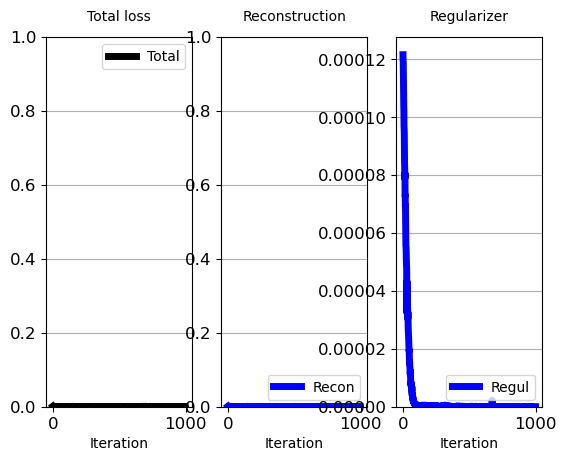

In [112]:
##################### TODO: Fill in the blank ##############################
# Create the network
SEED = 111111
rng = np.random.RandomState(seed=SEED)
vae_1 = VAE(rng=rng,
          D_in=length,
          D_hid_enc=100,
          D_bottleneck=2,  # <--- Set to correct value for instantiating VAE shown & implemented in Task 1. Note: We treat D as dimensionality of Z, rather than number of neurons.
          D_hid_dec=100)
########################################################################
# Start training
unsupervised_training_VAE(vae_1,
                          vae_loss,
                          lambda_rec=0.5,  
                          lambda_reg=0.5,  
                          rng=rng,
                          train=train,
                          learning_rate=1e-4,
                          total_iters=1000,
                          iters_per_recon_plot=50)


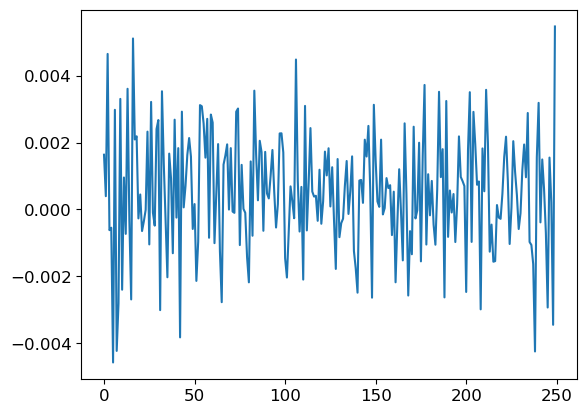

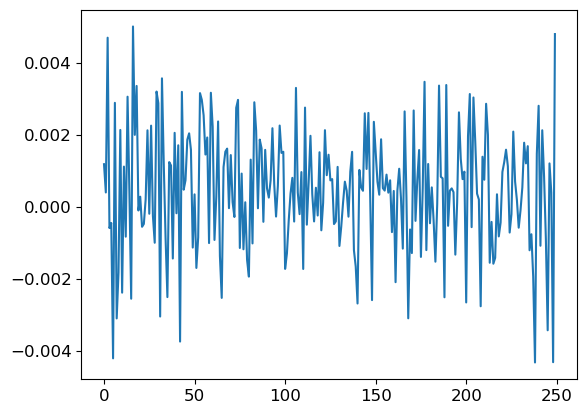

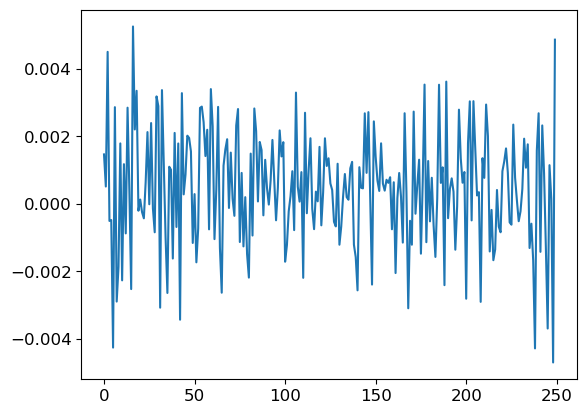

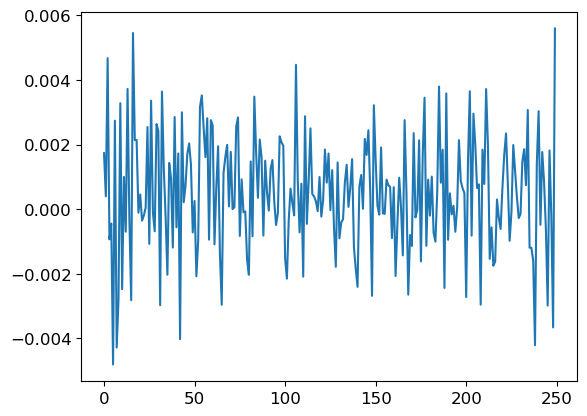

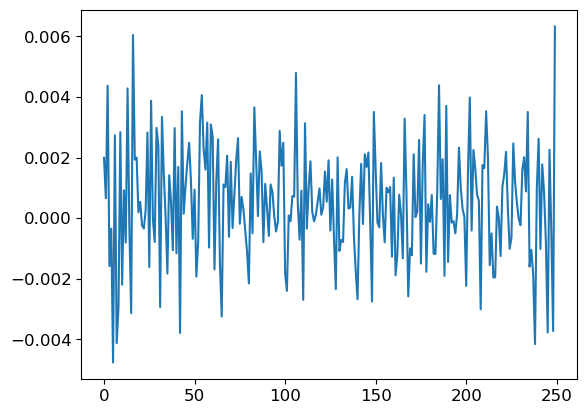

In [113]:
samples = synthesize(vae_1,
           rng,
           n_samples=5)


In [114]:
samples = pd.DataFrame(samples)
samples = samples.T
samples 

,0,1,2,3,4
0,0.001638,0.001185,0.001464,0.001735,0.001988
1,0.000397,0.000400,0.000512,0.000399,0.000656
2,0.004651,0.004699,0.004503,0.004674,0.004372
3,-0.000619,-0.000589,-0.000507,-0.000933,-0.001587
4,-0.000546,-0.000448,-0.000481,-0.000445,-0.000347
...,...,...,...,...,...
245,-0.002931,-0.003428,-0.003695,-0.002981,-0.003779
246,0.001552,0.001207,0.001145,0.001816,0.002254
247,0.000214,0.000396,0.000143,-0.000183,-0.000451
248,-0.003449,-0.004314,-0.004701,-0.003658,-0.003730


[iter: 0 ]: Total training Loss: 0.00


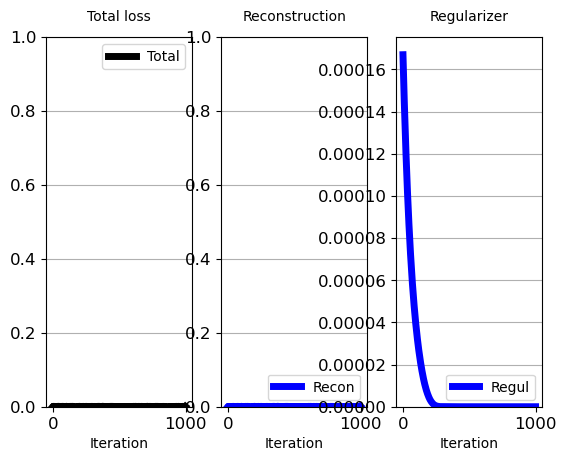

In [115]:
##################### TODO: Fill in the blank ##############################
# Create the network
SEED = 111111
rng = np.random.RandomState(seed=SEED)
vae_2 = VAE_2(rng=rng,
          D_in=length)
########################################################################
# Start training
unsupervised_training_VAE(vae_2,
                          vae_loss,
                          lambda_rec=0.5,  
                          lambda_reg=0.5,  
                          rng=rng,
                          train=train,
                          learning_rate=1e-4,
                          total_iters=1000,
                          iters_per_recon_plot=50)


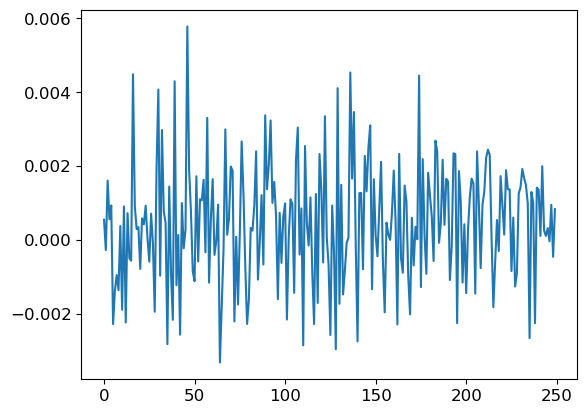

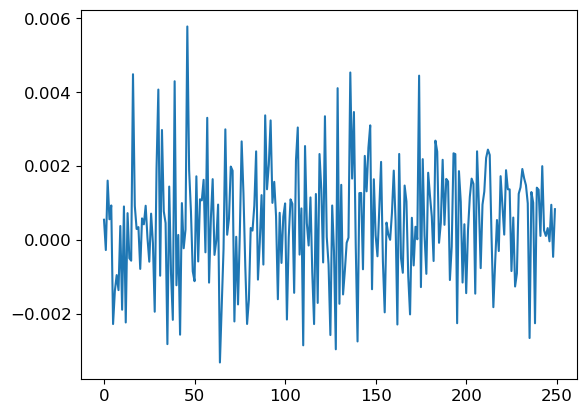

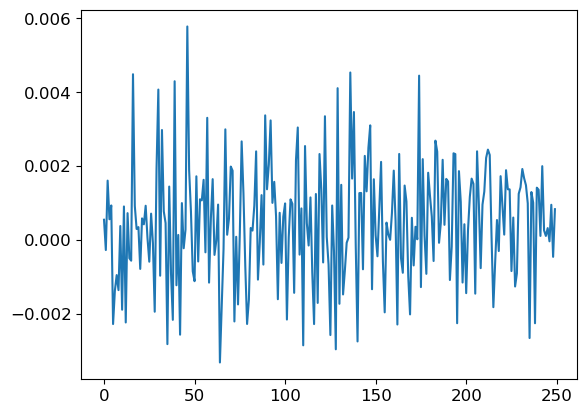

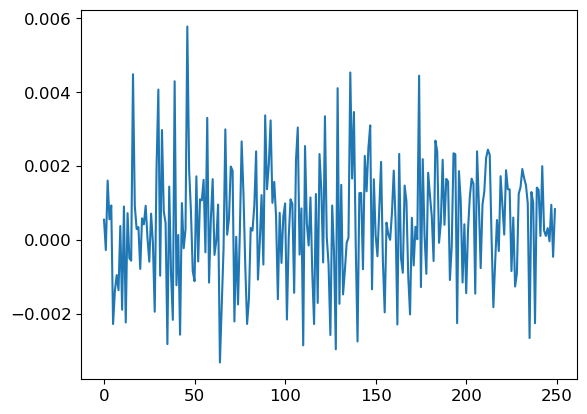

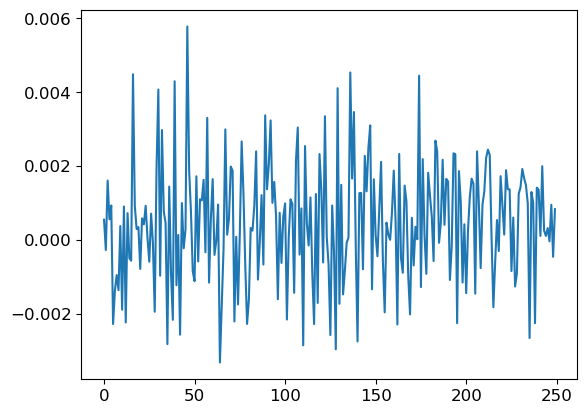

In [116]:
samples = synthesize(vae_2,
           rng,
           n_samples=5)

In [95]:
samples = pd.DataFrame(samples)
samples = samples.T
samples

,0,1,2,3,4
0,0.000222,0.000222,0.000222,0.000222,0.000222
1,-0.001073,-0.001073,-0.001073,-0.001073,-0.001073
2,0.001812,0.001812,0.001812,0.001812,0.001812
3,-0.000319,-0.000319,-0.000319,-0.000319,-0.000319
4,0.000214,0.000214,0.000214,0.000214,0.000214
...,...,...,...,...,...
245,-0.000575,-0.000575,-0.000575,-0.000575,-0.000575
246,-0.000231,-0.000231,-0.000231,-0.000231,-0.000231
247,0.000708,0.000708,0.000708,0.000708,0.000708
248,0.000722,0.000722,0.000722,0.000722,0.000722


## GAN

In [96]:
# -*- coding: utf-8 -*-
import torch
import torch.optim as optim
import torch.nn as nn

lrelu = nn.LeakyReLU(0.2)

class Network():
    
    def backward_pass(self, loss):
        # Performs back propagation and computes gradients
        # With PyTorch, we do not need to compute gradients analytically for parameters were requires_grads=True, 
        # Calling loss.backward(), torch's Autograd automatically computes grads of loss wrt each parameter p,...
        # ... and **puts them in p.grad**. Return them in a list.
        loss.backward()
        grads = [param.grad for param in self.params]
        return grads
     
class Generator(Network):
    def __init__(self, rng, D_z, D_hid1, D_hid2, D_data):
        self.D_z = D_z  # Keep track of it, we may need it.
        # Initialize weight matrices
        # Dimensions of parameter tensors are (number of neurons + 1) per layer, to account for +1 bias.
        # First 2 hidden layers
        w1_init = rng.normal(loc=0.0, scale=np.sqrt(2./(D_z * D_hid1)), size=(D_z + 1, D_hid1))
        w2_init = rng.normal(loc=0.0, scale=np.sqrt(2./(D_hid1 * D_hid2)), size=(D_hid1 + 1, D_hid2))
        # -- Output layer, predicting p(real|x)
        wout_init = rng.normal(loc=0.0, scale=np.sqrt(2./(D_hid2 * D_data)), size=(D_hid2 + 1, D_data))

        # Pytorch tensors, parameters of the model
        # Use the above numpy arrays as of random floats as initialization for the Pytorch weights.
        w1 = torch.tensor(w1_init, dtype=torch.float, requires_grad=True)
        w2 = torch.tensor(w2_init, dtype=torch.float, requires_grad=True)
        wout = torch.tensor(wout_init, dtype=torch.float, requires_grad=True)
        
        # Keep track of all trainable parameters:
        self.params = [w1, w2, wout]
        
        
    def forward(self, batch_z):
        # z_codes: numpy array or pytorch tensor, shape [N, dimensionality of data]
        [w1, w2, wout] = self.params
        # make numpy to pytorch tensor
        batch_z_t = torch.tensor(batch_z, dtype=torch.float) if type(batch_z) is np.ndarray else batch_z
        # add 1 element for bias
        unary_feature_for_bias = torch.ones(size=(batch_z_t.shape[0], 1))  # [N, 1] column vector.
        
        # ========== TODO: Fill in the gaps ========
        # hidden layer:
        z_ext = torch.cat((batch_z_t, unary_feature_for_bias), dim=1)
        h1_preact = z_ext.mm(w1)
        h1_act = lrelu(h1_preact)  
        # l2
        h1_ext = torch.cat((h1_act, unary_feature_for_bias), dim=1)
        h2_preact = h1_ext.mm(w2)
        h2_act = lrelu(h2_preact)
        # output layer.
        h2_ext = torch.cat((h2_act, unary_feature_for_bias), dim=1)
        hout_preact = h2_ext.mm(wout)
        hout_act = torch.tanh(hout_preact)
        # ==========================================
        
        # Output
        x_generated = hout_act  # [N_samples, dimensionality of data]
        
        return x_generated
                        
        
class Discriminator(Network):
    def __init__(self, rng, D_data, D_hid1, D_hid2):
        # Initialize weight matrices
        # Dimensions of parameter tensors are (number of neurons + 1) per layer, to account for +1 bias.
        # -- 2 hidden layers
        w1_init = rng.normal(loc=0.0, scale=np.sqrt(2. / (D_data * D_hid1)), size=(D_data + 1, D_hid1))
        w2_init = rng.normal(loc=0.0, scale=np.sqrt(2. / (D_hid1 * D_hid2)), size=(D_hid1 + 1, D_hid2))
        # -- Output layer, predicting p(real|x)
        wout_init = rng.normal(loc=0.0, scale=np.sqrt(2. / D_hid2), size=(D_hid2 + 1, 1))
        
        # Pytorch tensors, parameters of the model
        # Use the above numpy arrays as of random floats as initialization for the Pytorch weights.
        w1 = torch.tensor(w1_init, dtype=torch.float, requires_grad=True)
        w2 = torch.tensor(w2_init, dtype=torch.float, requires_grad=True)
        wout = torch.tensor(wout_init, dtype=torch.float, requires_grad=True)
        
        # Keep track of all trainable parameters:
        self.params = [w1, w2, wout]
        
        
    def forward(self, batch_x):
        # z_codes: numpy array or pytorch tensor, shape [N, dimensionality of data]
        [w1, w2, wout] = self.params
        # make numpy to pytorch tensor
        batch_x_t = torch.tensor(batch_x, dtype=torch.float) if type(batch_x) is np.ndarray else batch_x
        # Add 1 element or bias
        unary_feature_for_bias = torch.ones(size=(batch_x_t.shape[0], 1)) # [N, 1] column vector.
        
        # ========== TODO: Fill in the gaps ========
        # hidden layer:
        x_ext = torch.cat((batch_x_t, unary_feature_for_bias), dim=1)
        h1_preact = x_ext.mm(w1)
        h1_act = lrelu(h1_preact)
        # layer 2
        h1_ext = torch.cat((h1_act, unary_feature_for_bias), dim=1)
        h2_preact = h1_ext.mm(w2)
        h2_act = lrelu(h2_preact)
        # output layer.
        h2_ext = torch.cat((h2_act, unary_feature_for_bias), dim=1)
        hout_preact = h2_ext.mm(wout)
        hout_act = torch.sigmoid(hout_preact)
        # ===========================================
        
        # Output
        p_real = hout_act
        
        return p_real
    

def generator_loss_practical(p_generated_x_is_real):
    # mu: Tensor, [number of samples]. Predicted probability D(G(z)) that fake data are real. 
    
    ######## TODO: Complete the gap ###########
    loss_per_sample = - torch.log(p_generated_x_is_real)
    ###########################################
    expected_loss = torch.mean(loss_per_sample, dim=0) # Expectation of loss: Mean over samples (axis=0).
    return expected_loss


def discriminator_loss(p_real_x_is_real, p_generated_x_is_real):
    # p_real_x_is_real: [N] Predicted probability D(x) for x~training_data that real data are real. 
    # p_generated_x_is_real: [N]. Predicted probability D(x) for x=G(z) where z~N(0,I) that fake data are real.
    
    ######## TODO: Complete the calculation of Reconstruction loss for each sample ###########
    loss_per_real_x = - torch.log(p_real_x_is_real)
    exp_loss_reals = torch.mean(loss_per_real_x)
    
    loss_per_fake_x = - torch.log(1 - p_generated_x_is_real)
    exp_loss_fakes = torch.mean(loss_per_fake_x)
    ##########################################################################################
    
    total_loss = exp_loss_reals + exp_loss_fakes  # Expectation of loss: Mean over samples (axis=0).
    return total_loss


In [104]:
from plotting import plot_train_progress_GAN # Use out of the box

def get_random_batch(train, rng, train_batches, length, stocks):
    batch = rng.randint(low=0, high=train_batches, size=1, dtype='int32')
    # print('Using batch:', batch, 'of', train.shape[0])
    train_batch= train[batch]
    train_batch= train_batch.reshape(length, stocks)
    # train_batch = train_batch[:, np.random.permutation(train_batch.shape[1])]
    return np.transpose(train_batch)

def unsupervised_training_GAN(generator,
                              discriminator,
                              loss_func_g,
                              loss_func_d,
                              rng,
                              train,
                              batch_size_g,
                              batch_size_d_fakes,
                              batch_size_d_reals,
                              learning_rate_g,
                              learning_rate_d,
                              total_iters_g,
                              inner_iters_d,
                              iters_per_gen_plot=-1):
    # generator: Instance of a Generator.
    # discriminator: Instance of a Discriminator.
    # loss_func_g: Loss functions of G
    # loss_func_d: Loss functions of D
    # rng: numpy random number generator
    # train_imgs_all: All the training images. Numpy array, shape [N_tr, H, W]
    # batch_size_g: Size of the batch for G when it is its turn to get updated.
    # batch_size_d_fakes: Size of batch of fake samples for D when it is its turn to get updated.
    # batch_size_d_reals: Size of batch of real samples for D when it is its turn to get updated.
    # learning_rate_g: Learning rate for G.
    # learning_rate_d: learning rate for D.
    # total_iters_g: how many SGD iterations to perform for G in total (outer loop).
    # inner_iters_d: how many SGD iterations to perform for D before every 1 SGD iteration of G.
    # iters_per_gen_plot: Integer. Every that many iterations the model generates few examples and we plot them.
    loss_g_to_plot = []
    loss_d_to_plot = []
    loss_g_mom_to_plot = []
    loss_d_mom_to_plot = []
    loss_g_mom = None
    loss_d_mom = None
    
    optimizer_g = optim.Adam(generator.params, lr=learning_rate_g, betas=[0.5, 0.999], eps=1e-07, weight_decay=0)  # Will use PyTorch's Adam optimizer out of the box
    optimizer_d = optim.Adam(discriminator.params, lr=learning_rate_d, betas=[0.5, 0.99], eps=1e-07, weight_decay=0)  # Will use PyTorch's Adam optimizer out of the box
    train_batches = train.shape[0] # N hereafter. Number of training images in database.
    length = train.shape[1] # H hereafter
    stocks = train.shape[2]

    for t in range(total_iters_g):
        
        for k in range(inner_iters_d):
            # Train Discriminator for inner_iters_d SGD iterations...
            
            ################## TODO: Fill in the gaps #######################
            # Generate Fake samples with G
            z_batch = np.random.normal(loc=0., scale=1., size=[train_batches, generator.D_z])
            x_gen_batch = generator.forward(z_batch)
            # Forward pass of fake samples through D
            p_gen_x_are_real = discriminator.forward(x_gen_batch)
            
            # Forward pass of real samples through D
            x_reals_batch= get_random_batch(train, rng=rng, train_batches=train_batches, length=length, stocks=stocks)
            p_real_x_are_real = discriminator.forward(x_reals_batch)
            
            # Compute D loss:
            loss_d = loss_func_d(p_real_x_are_real, p_gen_x_are_real)
            ####################################################################
            
            # Backprop to D
            optimizer_d.zero_grad()
            _ = discriminator.backward_pass(loss_d)
            optimizer_d.step()
            
        ############## Train Generator for 1 SGD iteration ############
        
        ########## TODO: Fill in the gaps ##################################
        # Generate Fake samples with G
        z_batch = np.random.normal(loc=0., scale=1., size=[batch_size_g, generator.D_z])
        x_gen_batch = generator.forward(z_batch)
        # Forward pass of fake samples through D
        p_gen_x_are_real = discriminator.forward(x_gen_batch)
        ####################################################################
        
        # Compute G loss:
        loss_g = loss_func_g(p_gen_x_are_real)
        
        # Backprop to G
        optimizer_g.zero_grad()
        _ = generator.backward_pass(loss_g)
        optimizer_g.step()
        
        # ==== Report training loss and accuracy ======
        loss_g_np = loss_g if type(loss_g) is type(float) else loss_g.item()
        loss_d_np = loss_d if type(loss_d) is type(float) else loss_d.item()
        if t % 10 == 0:  # Print every 10 iterations
            print("[iter:", t, "]: Loss G: {0:.2f}".format(loss_g_np), " Loss D: {0:.2f}".format(loss_d_np))

        loss_g_mom = loss_g_np if loss_g_mom is None else loss_g_mom * 0.9 + 0.1 * loss_g_np
        loss_d_mom = loss_d_np if loss_d_mom is None else loss_d_mom * 0.9 + 0.1 * loss_d_np

        loss_g_to_plot.append(loss_g_np)
        loss_d_to_plot.append(loss_d_np)
        loss_g_mom_to_plot.append(loss_g_mom)
        loss_d_mom_to_plot.append(loss_d_mom)
        
        # # =============== Every few iterations, plot loss ================#
        # if t == total_iters_g - 1 or t % iters_per_gen_plot == 0:
            
        #     ########## TODO: Fill in the gaps #############################
        #     # Generate Fake samples with G
        #     n_samples_to_gen = 100
        #     z_plot = np.random.normal(loc=0., scale=1., size=[100, generator.D_z])
        #     x_gen_plot = generator.forward(z_plot)
        #     # Cast tensors to numpy arrays
        #     x_gen_plot_np = x_gen_plot if type(x_gen_plot) is np.ndarray else x_gen_plot.detach().numpy()
        #     ###############################################################
            
        #     # Generated images have vector shape. Reshape them to original image shape.
        #     x_gen_plot_resh = x_gen_plot_np.reshape([n_samples_to_gen, H_height, W_width])
            
        #     train_imgs_resh = train_imgs_all.reshape([train_imgs_all.shape[0], H_height, W_width])
            
            
            # Plot a few generated images.
            # plot_grids_of_images([x_gen_plot_resh[0:100], train_imgs_resh[0:100]],
            #                       titles=["Generated", "Real"],
            #                       n_imgs_per_row=10,
            #                       dynamically=True)
            
    # In the end of the process, plot loss.
    plot_train_progress_GAN(loss_g_to_plot, loss_d_to_plot,
                            loss_g_mom_to_plot, loss_d_mom_to_plot,
                            iters_per_point=1, y_lims=[3., 3.])
    

In [105]:
def synthesize(generator, n_samples):

    

    # Generate Fake samples with G
    z_plot = np.random.normal(loc=0., scale=1., size=[n_samples, generator.D_z])
    x_gen_plot = generator.forward(z_plot)
    # Cast tensors to numpy arrays
    x_gen_plot_np = x_gen_plot if type(x_gen_plot) is np.ndarray else x_gen_plot.detach().numpy()

    # Generated images have vector shape. Reshape them to original image shape.
    # x_gen_plot_resh = x_gen_plot_np.reshape([n_samples, H_height, W_width])
# return   x_samples_np    
    for x_sample in x_gen_plot_np:
        plt.plot(x_sample)
        plt.show()
        plt.pause(0.1)

    return x_gen_plot_np  

[iter: 0 ]: Loss G: 0.61  Loss D: 1.40
[iter: 10 ]: Loss G: 0.65  Loss D: 1.39
[iter: 20 ]: Loss G: 0.68  Loss D: 1.39
[iter: 30 ]: Loss G: 0.69  Loss D: 1.39
[iter: 40 ]: Loss G: 0.69  Loss D: 1.39
[iter: 50 ]: Loss G: 0.70  Loss D: 1.39
[iter: 60 ]: Loss G: 0.69  Loss D: 1.39
[iter: 70 ]: Loss G: 0.69  Loss D: 1.40
[iter: 80 ]: Loss G: 0.71  Loss D: 1.39
[iter: 90 ]: Loss G: 0.69  Loss D: 1.39
[iter: 100 ]: Loss G: 0.69  Loss D: 1.39
[iter: 110 ]: Loss G: 0.69  Loss D: 1.39
[iter: 120 ]: Loss G: 0.70  Loss D: 1.38
[iter: 130 ]: Loss G: 0.69  Loss D: 1.39
[iter: 140 ]: Loss G: 0.70  Loss D: 1.38
[iter: 150 ]: Loss G: 0.69  Loss D: 1.39
[iter: 160 ]: Loss G: 0.69  Loss D: 1.39
[iter: 170 ]: Loss G: 0.69  Loss D: 1.39
[iter: 180 ]: Loss G: 0.69  Loss D: 1.39
[iter: 190 ]: Loss G: 0.69  Loss D: 1.39
[iter: 200 ]: Loss G: 0.69  Loss D: 1.39
[iter: 210 ]: Loss G: 0.69  Loss D: 1.39
[iter: 220 ]: Loss G: 0.70  Loss D: 1.38
[iter: 230 ]: Loss G: 0.69  Loss D: 1.40
[iter: 240 ]: Loss G: 0.69 

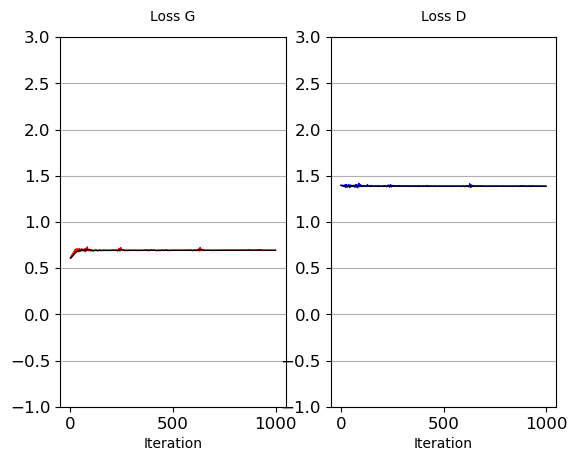

In [106]:
# Create the network
SEED = 111111
rng = np.random.RandomState(seed=SEED)
generator = Generator(rng=rng,
                      D_z=1,
                      D_hid1=100,
                      D_hid2=200,
                      D_data=length)
discriminator = Discriminator(rng=rng,
                              D_data=length,
                              D_hid1=200,
                              D_hid2=100)

# Start training
unsupervised_training_GAN(generator,
                          discriminator,
                          loss_func_g=generator_loss_practical,
                          loss_func_d=discriminator_loss,
                          rng=rng,
                          train=train,
                          batch_size_g=32,
                          batch_size_d_fakes=64,
                          batch_size_d_reals=64,
                          learning_rate_g=1e-3,
                          learning_rate_d=1e-3,
                          total_iters_g=1000,
                          inner_iters_d=1,
                          iters_per_gen_plot=100)

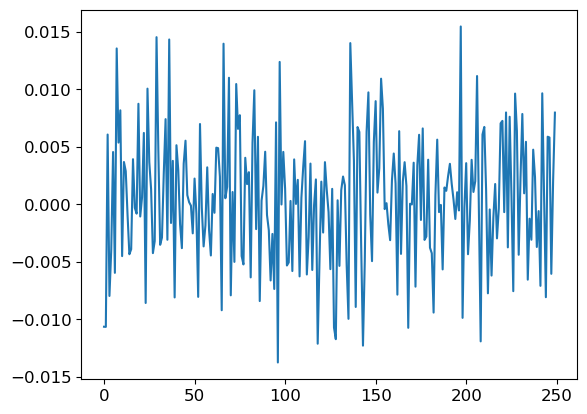

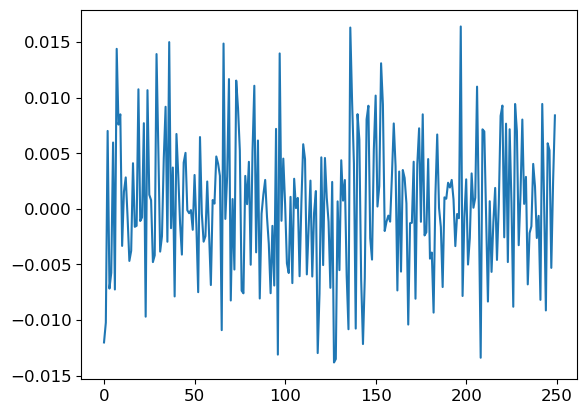

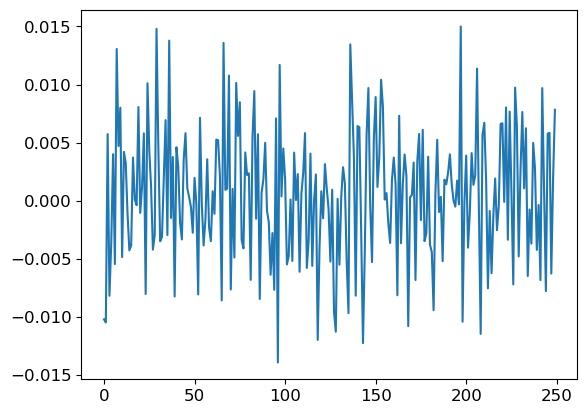

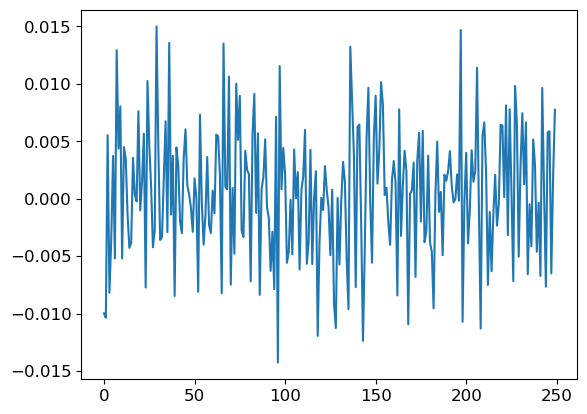

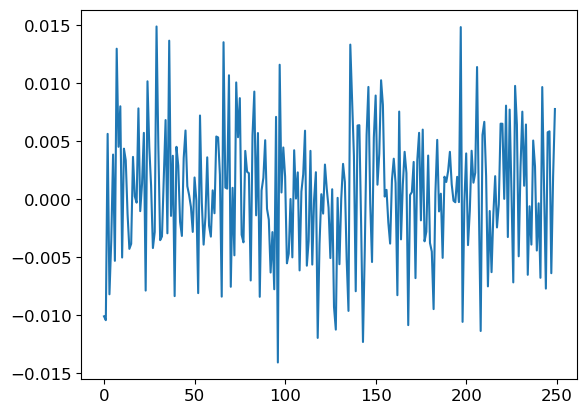

In [107]:
samples = synthesize(generator, 5)

In [108]:
samples = pd.DataFrame(samples)
samples = samples.T
samples

,0,1,2,3,4
0,-0.010655,-0.012013,-0.010215,-0.009987,-0.010097
1,-0.010668,-0.010229,-0.010483,-0.010363,-0.010430
2,0.006074,0.007003,0.005738,0.005532,0.005632
3,-0.007975,-0.007168,-0.008183,-0.008191,-0.008198
4,-0.003932,-0.005751,-0.003638,-0.003532,-0.003573
...,...,...,...,...,...
245,0.005885,0.005891,0.005769,0.005773,0.005769
246,0.005817,0.005256,0.005839,0.005874,0.005852
247,-0.006049,-0.005309,-0.006273,-0.006496,-0.006381
248,0.002058,0.002527,0.002016,0.001975,0.001994
